--- 
Project for the course in Microeconometrics | Summer 2021, M.Sc. Economics, Bonn University | [Philipp Schreiber](https://github.com/pcschreiber1)

# Replication of Henderson, Storeygard, Deichmann (2017) :
## Has climate change driven urbanization in Africa? <a class="tocSkip">   
    
    
---

<div class="alert alert-block alert-info">
    <h5><b>Downloading and viewing this notebook:</b></h5> <p> The original paper, as well as the data and code provided by the authors can be accessed <a href="https://doi.org/10.1016/j.jdeveco.2016.09.001">here</a> </p></div>

## Content:
Extension: 
 - Spatial SUTVA/ <span style="color:orange">**NOTE**:</span> How large are the districts (important for whetehr SUTVA is reasonable or not)
 - Spatially explicit counterfactual framework
     - using exploration of SUTVA and spatial patters
         - spatial autocorrelation: Moran Plot and Moran's I
     - implementing (lagged dependent, lagged 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import statsmodels.formula.api as smf
import seaborn as sns

#For spatial analysis
import geopandas as gpd
import shapely.geometry as geom
import libpysal as lp #For spatial weights

from pysal.viz import splot #exploratory analysis
#from splot.esda import plot_moran #exploratory analysis
from pysal.explore import esda #exploratory analysis
from pysal.model import spreg #For spatial regression

pd.options.display.float_format = "{:,.2f}".format

In [2]:
from auxiliary.data_import import *
from auxiliary.plots import *
from auxiliary.simulations import *
from auxiliary.tables import *

In [3]:
#map_countries()

In [100]:
# The explanatory variables of interest
a = ["ADsm0_1moistu",
     "ADsm0_2moistu",
     "ADsm0_3moistu",
     "ADsm0_4moistu",
     "extent_agE_ADsm0_2moistu",
     "ADurbfrac",
     "extent_agE",
     "extent_agH",
     "primate"]

regressors = ["ADsm0_2moistu",
              "extent_agE_ADsm0_2moistu",
              "extent_agH_ADsm0_2moistu",
              "extent_agE",
              "extent_agH",
              "firsturbfrac",
              "lndiscst"]

---
# 1. Introduction 
---

In this paper Henderson et al. investigate the impact of increasing aridity on urbanization in Sub-Saharan Africa. In particular, the authors address the questions of i) *whether adverse changes in climate induce a push from rural to urban areas* and ii) *how this within-country migration affects incomes in cities/ the nature of the development effect of such an urbanization push on cities*.  They attribute previous studies' lack of significant findings to aggregation due to using national level data and, therefore, use variation at the district and city level. In addition, they construct a new data set of actual census data to overcome the reliance on interpolations, including the use of **night time lights (NTLs)**.

<img src="material/map_countries.PNG" alt="Error: map_countries.png" title="countries in the data set" width="600"/>

The authors outline a simple model of rural-urban migration to frame their analysis of the impact of rising aridity. The model suggests ...
<span style="color:red">***Shorter*** </span> <span style="color:blue">The authors model districs as small open economies which are differentiated by the presence of manufacturing facilities for potentially tradeable goods. In this context, a decline in moisture should only induce local migration in industrialized districts, since in exclusievly rural districts cities are only provide agriculture with services that not traded across districts, the local agricultural sector is not competing for labor.</span> This study employs **fixed effects (FE) regression** to account for all relevant influences. Finally, the authors support this by looking at evidence from India. The authors find strong evidence for the local migration, nut only in districts likely to produce tradable manufacturing goods. Similary, total income of local cities also only increases in districts liekly to produce tradable manufacturing goods. Understanding the patterns and effects of climate change on urbanization  is important both for providing assistance and to guide proactive policy. Africa projected to be especially affected by climate change ... Sucessful spatial and structural adaptation to climate change will critically depend on promoting cities' capacities.



<span style="color:blue">In this notebook, I replicate the results presented in the paper by Lindo et al. (2010). Furthermore, I discuss in detail the identification strategy used by the authors and evaluate the results using multiple robustness checks. My analysis offers general support for the findings of Lindo et al. (2010) and points out some factors which may enable a deeper understanding of the causal relationship explored in the paper. </span> In particular, I show that the SUTVA assumption is violated through spatial interdependence and **introduce a spatially explicity counterfactual model as an alternative**.

<span style="color:blue"> This notebook is structured as follows. In the next section, I present the performance standard model that lays down the theoretical framework for the paper (Section 2). In Section 3, I analyze the identification strategy that Lindo et al. (2010) use to unravel the causal effects of academic probation on student outcomes and Section 4 briefly discusses the empirical strategy the authors use for estimation. Section 5 and Section 6 constitute the core of this notebook. Section 5 shows my replication of the results in the paper and discussion thereof. In Section 6 I conduct various robustness checks and discuss some limitations of the paper. Section 7 offers some concluding remarks. </span>



---
# 2. Theoretical Background/ Literature
---

<span style="color:red">***What should be discussed here?*** </span>
<ul type="circle">  
 <li > <span style="color:blue"> What the literature says about this issues </span> </li>  
 <li> <span style="color:blue">  How urban migration and migration in the context of climate change has been studied </span> </li>  
</ul>

<span style="color:red">***Urban Models*** </span> <span style="color:blue"> 
     Mentioned in Henderson et al. 2017: (Duranton and Puga, 2004), (Desmet and Henderson, 2015)  
     Moreover: One of the earlier papers by henderson on urban model (Black and Henderson, 1999) </span> 

---
# 3. Data
---

In what follows I present the data. A study of 29 countries over the span ?30? years with subnational data require a sophisticated data set. For further detail, refer to the appendix of the original paper.

<h3><u>3.1 Urbanization</u></h3>
(urbanization over 10-15 years as a function of climate chnage over those years)

Most studies employ **population data** from infrequente national census reports and rely heavily on imputations and interpolations. This study includes countries with at least two available censuses with the relevant information for a complete or nearly complete set of sub-national units, where either district boundaries changed little or common units over time can be defined. The authors digitized data from hardycopy census publications. Of the 32 countries, Namibia, Congo-Brazzaville and Liberia were dropped due to issues of district definition or census frequency. The 29 remaining countries count between 2 to 5 censuses between 1960 and 2019. For estimation purposes Kenya is treated as two countries before and after the urban redefinition of the 1990s. While extensive, the sample omits several Sub-Saharan countries, most notably Nigeria, the most populous country on the continent. The countries were omitted either because the censuses did not include the needed information or printed volumes were unavailable. South Africa was excluded because of Post-Apartheid migration. Districs are large ... <span style="color:blue"> Need to explicitly say how "urban population" is measured. </span>

In contrast, high quality **climate data** is much more readily available. To reflect climatic agricultural potential the authors use precipitation over potential evapotranspiration (i.e. system supply over system demand) as a moisture index. The precipitation and temperature data is available from the University of Delaware gridded climate data set while PET is estimated using the Thornthwaite method. The district level climate indicator is then the average grid cell value that overlaps with the corresponding sub-national unit where cells that cross the boundary are weighted.

Sub-national **data on industrialization** is scarce in many census reports - before 1985 this is even true for national level indicators. Henderson et al. draw on the *Oxford Regional Economic Atlas, Africa* (Ady, 1965) which map all industries by type and city location, based on an in-depth analysis from a variety of sources from the late 1950s and early 1960s. From the total 26 industries the authors exclude 10 agricultural processing industries (e.g. brewing, milling) and use the count of different industries as the industrialization indicator. The full 26 industries have been used in robustness checks.

<h3><u>3.2 Income</u></h3>
(impact of annual climate fluctuations on annual city incomes and implied (possibly short-term) migration)

Due to the lack of consistently available **data on total city income**, **night time lights (NTLs)** are used as a proxy. The authors use annual average data from 1992 to 2008 using data from the U.S. Defense Meteorological Satellite Program (DMSP). As is typical in socioeconomic analysis, clouds and rainfally are excluded and only stable light sources are included. City income is then mapped as the sum of the light intensity of every pixel in the outer envelope. For further information on the use of NTLs see ... .  <span style="color:red">***Also*** </span> <span style="color:blue"> Established strong connection NTL and Henderson, Storeygard, and Weil (2012) was one of the first to formally test the relationship between changes in lights and economic growth</span> 

Since traditional **climate indexes** such as the moisture index are not available at such fine resolutions, rainfall is used instead. The data is used from the Rainfall Climatology Version 2, which combines weather station data with satellity information. Each city's hinterland annual average rainfall is then the average of grid-cell values within 30km of the ever-lit area. Since the moisture index split the sample almost evenly, "we calculate average near-city rainfall between 1983 (the first year in the data) and 1991, and split at the sample median".


---
# 4. Identification
--- 

Disaggregated data for such an extended period of time is extremely scarce, hence the analysis can only rely on a few key variables. As the authors explain, the income study can almost be seen as a robustness check of whether migration is really driving the effect here.

(The biggest threat that the authors are concerned about are unobserved confounders.)

(Identification issues with proxies as "collider variables" (SUTVA paper Yale) -> problematic for NTLs?)
Hence, consider the following tree: (showing a fixed effect appropriate tree)

In [5]:
#import the data
regiondata = get_spatialdata()

C:\projects\ose-data-science-course-project-pcschreiber1\auxiliary\data_import.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regiondata["geometry"] = regiondata[["lon", "lat"]].apply(geom.Point, axis=1) #take each row


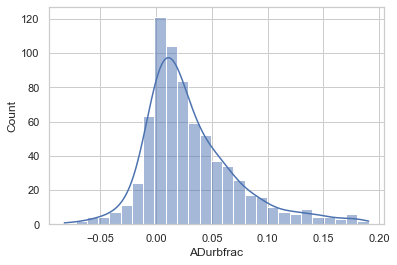

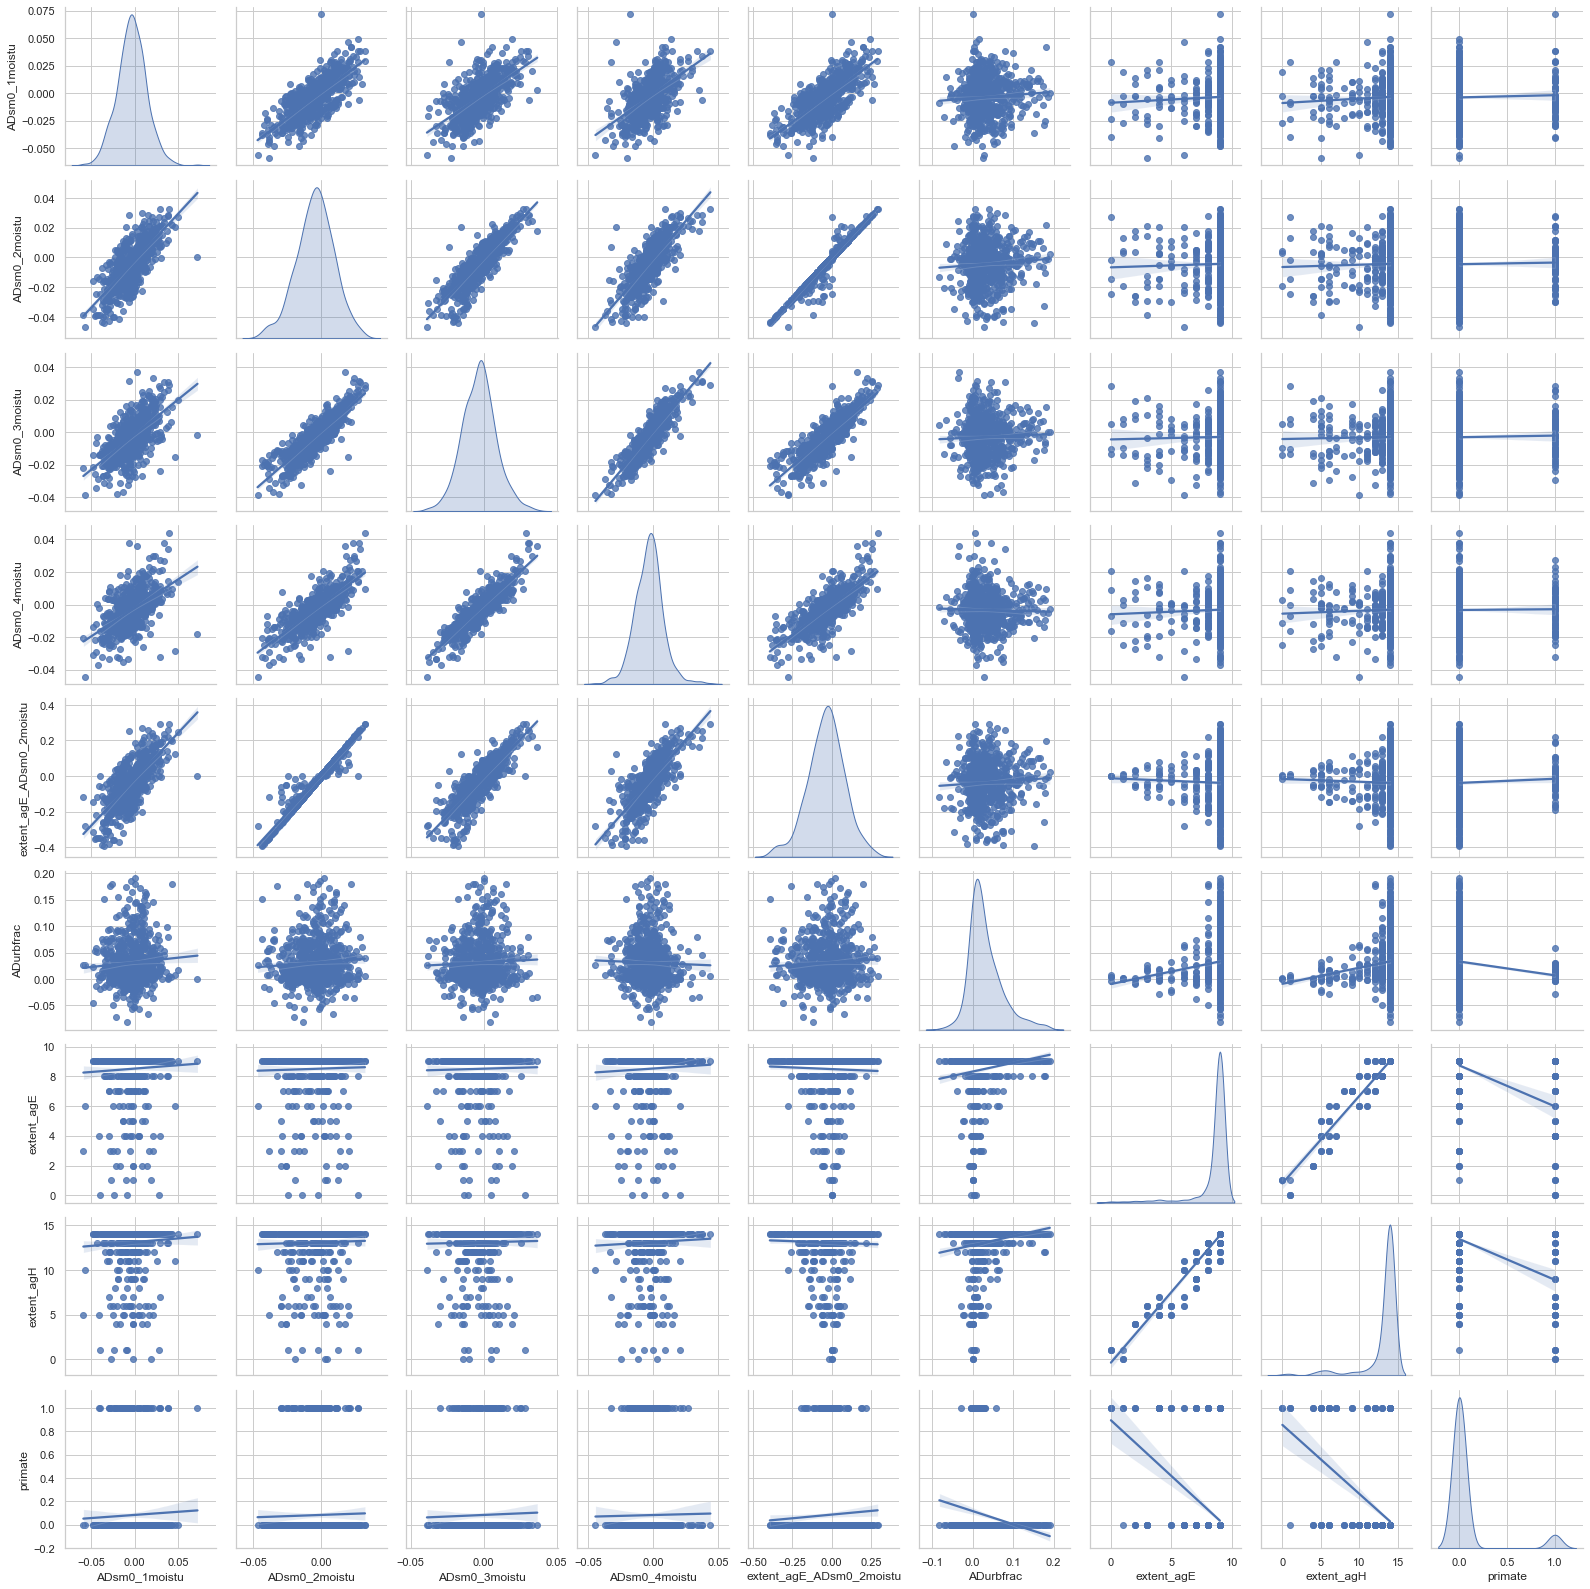

In [6]:
sns.set_theme(style='whitegrid')
sns.histplot(x=regiondata['ADurbfrac'], kde=True)
_ = sns.pairplot(regiondata[a], kind='reg', diag_kind='kde')

<h3><u>4.1 Fixed Effecs</u></h3>

Consider the following 

In the social science literature, two-way fixed effects (2FE) are extremely popular tools for accounting for both unit-specific (but time-invariant) and time-specific (but unit-invariant) *unobserved* confounders in a flexible manner. However, as Imai and Kim (2020) illustrate, their application requires careful consideration of the identification assumptions: besides the assumption of additivity and seperability of the unobserved variables, it also critically relies on the linearity of their effects. Moreover, the authors call into question 2FE's attractive connection to the explicitly causal framework fo difference-in-difference (DiD) and conclude that "the general multi-period DiD estimator is equivalent to the weighted two-way fixed effects regression estimator, but some oberservations have invalid (i.e.) negative weights" (p.9).

<img src="material/2FE_DAG_1.PNG" alt="Error: 2FE_DAG_1" style="width: 700;"/>

In the context of the present study, some unobserved covariates that immediately come to mind are local culture, developments in infrastructure and the green revolution in agricultural production. These are all effects which can be accounted for using time and unit fixed effects

The most serious challenge to the 2FE specification concerns the industry data. While the presence of industry is supposed to be the key determinant of the effect of a decrease in moisture, we only observe a snapshot from the 1960s level. Hence, the analysis critically relies on the assumption that 1960s levels of industrialization are representative for the whole period. In relation to the 2FE regression, this means that the local industrial development was linear and only influenced by local constants and global pushes. In particular, this neglects the presence of a vast amount of natioanl and sub-national industrialization policies. Neither can the 2FE specification capture the effect of local policies directly related to urban development and migration.

---
# 5. Results
---

<h3><u>5.1 Climate change and urbanization</u></h3>

In [6]:
regiondata = pd.read_stata("data/regiondata.dta")
#define order of display
regressors = ["ADsm0_2moistu",
              "extent_agE_ADsm0_2moistu",
              "extent_agH_ADsm0_2moistu",
              "extent_agE",
              "extent_agH",
              "firsturbfrac",
              "lndiscst"]

specification = {"2.1 - No industry": 
                      ["ADsm0_2moistu",
                       "firsturbfrac",
                       "lndiscst"],
                 "2.2 - Modern industry": 
                      ["ADsm0_2moistu",
                       "extent_agE",
                       "extent_agE_ADsm0_2moistu",
                       "firsturbfrac",
                       "lndiscst"],
                 "2.3 - Total Industry": 
                      ["ADsm0_2moistu",
                       "extent_agH",
                       "extent_agH_ADsm0_2moistu",
                       "firsturbfrac",
                       "lndiscst"]}

#filtering out outliers
regiondata = regiondata.query("abspctileADsm0_2moistu > 6 & abspctileADurbfrac > 6")
#convert selected variables to permille
regiondata.loc[:, ["extent_agE", "extent_agH","firsturbfrac", "lndiscst"]] = regiondata.loc[:, ["extent_agE", "extent_agH","firsturbfrac", "lndiscst"]] /1000

get_table_regiondata(regressors, specification, regiondata)

As we can see, the impact of moisture becomes strongly statistically significant once we account for the presence (or absence) of industry.

Controlling for the robusteness of the moisture effect

Neighbor's precipation not relevant

In [14]:
regiondata[permille_vars]

,extent_agE,extent_agH,firsturbfrac,lndiscst,ADsm0_2moistulndiscst
0,9.00,14.00,0.36,6.64,0.10
1,9.00,14.00,0.22,6.72,-0.05
2,9.00,14.00,0.44,6.45,0.03
3,9.00,14.00,0.41,6.69,0.05
4,9.00,14.00,0.60,6.55,0.15
...,...,...,...,...,...
736,9.00,14.00,0.17,6.23,-0.20
737,9.00,14.00,0.00,5.88,-0.20
738,9.00,14.00,0.02,6.28,-0.11
739,7.00,9.00,0.24,6.25,-0.07


In [42]:
regiondata = pd.read_stata("data/regiondata.dta")
# specifying order of display
regressors = ["ADsm0_2moistu",
              "extent_agH_ADsm0_2moistu",
              "ADsm0_2moistu_nb",
              "extent_agH_ADsm0_2moistu_nb",
              "ADsm0_2preu",
              "ADsm0_2tmpu",
              "extent_agH_ADsm0_2preu",
              "extent_agH_ADsm0_2tmpu",
              "extent_agH",
              "firsturbfrac",
              "lndiscst",
              "ADsm0_2moistulndiscst"]

specification = {"3.1 - Original": 
                      ["ADsm0_2moistu",
                       "extent_agH_ADsm0_2moistu",
                       "ADsm0_2moistulndiscst",
                       "extent_agH",
                       "firsturbfrac",
                       "lndiscst"],
                 "3.2 - No interaction": 
                      ["ADsm0_2moistu",
                       "ADsm0_2moistulndiscst",
                       "extent_agH",
                       "firsturbfrac",
                       "lndiscst"],
                 "3.3 - Neighborhood effect": 
                      ["ADsm0_2moistu",
                       "ADsm0_2moistu_nb",
                       "extent_agH_ADsm0_2moistu",
                       "extent_agH_ADsm0_2moistu_nb",
                       "extent_agH",
                       "extent_agH_ADsm0_2moistu",
                       "firsturbfrac",
                       "lndiscst"],
                 "3.4 - Precipitation": 
                      ["ADsm0_2preu",
                       "extent_agH_ADsm0_2preu",
                       "extent_agH",
                       "firsturbfrac",
                       "lndiscst"],
                 "3.5 - Precipitation and temperature": 
                      ["ADsm0_2preu",
                       "extent_agH_ADsm0_2preu",
                       "ADsm0_2tmpu",
                       "extent_agH_ADsm0_2tmpu",
                       "extent_agH",
                       "firsturbfrac",
                       "lndiscst"]}

#filtering out outliers
regiondata = regiondata.query("abspctileADsm0_2moistu > 6 & abspctileADurbfrac > 6")
#convert selected variables to permille
permille_vars = ["extent_agE",
                 "extent_agH",
                 "firsturbfrac",
                 "lndiscst",
                 "ADsm0_2moistulndiscst"]
regiondata.loc[:, permille_vars] = regiondata.loc[:, permille_vars] /1000

get_table_regiondata(regressors, specification, regiondata)

Considering the effect at the national level (No fixed effects)

In [3]:
countrydata = pd.read_stata("data/countrydata.dta")
# specifying order of display
regressors = ["ADsm0_2moistu",
              "sum_agH",
              "ADsm0_2preu",
              "sum_agH_ADpreu",
              "sum_agH_ADmoistu",
              "sum_agH_primwide",
              "sum_agH_primwide_ADmoistu",
              "sum_agH_nonprimwide",
              "sum_agH_nonprimwide_ADmoistu"]

specification = {"5.1 - No industry": 
                      ["ADsm0_2moistu"],
                 "5.2 - No interaction": 
                      ["ADsm0_2moistu",
                       "sum_agH",
                       "sum_agH_ADmoistu"],
                 "5.3 - Precipation": 
                      ["ADsm0_2preu"],
                 "5.4 - Precipitation with Industry": 
                      ["ADsm0_2preu",
                       "sum_agH",
                       "sum_agH_ADpreu"],
                 "5.5 - Growth of captial city": 
                      ["ADsm0_2moistu",
                       "sum_agH_primwide",
                       "sum_agH_primwide_ADmoistu",
                       "sum_agH_nonprimwide",
                       "sum_agH_nonprimwide_ADmoistu"]}

get_table_countrydata(regressors, specification, countrydata)

<h3><u>5.2 Climate change and city income</u></h3>

Specification: $ln(light_{it}) = \sum^{k}_{j=0} \beta_{j} ln(rain_{i,t-j})+ \sum^{k}_{j=0}\gamma_{j}X_{j}' ln(rain_{i,t-j})+\phi_{i}+\lambda_{t} + \alpha_{i}t + \varepsilon_{it}$

In [61]:
citydata = pd.read_stata("data/citydata.dta")
# specifying order of display
regressors = ["dlnrain30",
              "extent_agE_dlnrain",
              "extent_agH_dlnrain",
              "D_ag30_dlnrain"]

specification = {"6.1 - No industry": 
                      ["dlnrain30"],
                 "6.2 - Modern industry": 
                      ["dlnrain30",
                       "extent_agE_dlnrain"],
                 "6.3 - Total industry": 
                      ["dlnrain30",
                       "extent_agH_dlnrain"],
                 "6.4 - Share of agriculture": 
                      ["dlnrain30",
                       "D_ag30_dlnrain"]}

get_table_citydata(regressors, specification, citydata)

Robustness

In [90]:
citydata = pd.read_stata("data/citydata.dta")
# specifying order of display
regressors = ["dlnrain30",
              "extent_agE_dlnrain",
              "extent_agH_dlnrain",
              "D_ag30_dlnrain"]

specification = {"7.1 - Regional aridity without industry": 
                      ["dlnrain30",
                       "hirain_dlnrain"],
                 "7.2 - Regional aridity with industry": 
                      ["dlnrain30",
                       "extent_agH_dlnrain",
                       "hirain_dlnrain",
                       "hirain_extent_agH_dlnrain"],
                 "7.3 - Lagged effect of rainfall": 
                      ["dlnrain30",
                       "extent_agH_dlnrain",
                       "Ldlnrain30",
                       "Lextent_agH_dlnrain"],
                 "7.4 - Lead effect of rainfall": 
                      ["dlnrain30",
                       "extent_agH_dlnrain",
                       "Fdlnrain30",
                       "Fextent_agH_dlnrain"]}

get_table_citydata(regressors, specification, citydata)

---
# Mechanisms
---

<span style="color:orange">**NOTE**:</span> While the paper also discusses micro-evidence from DHS surveys in India, no information is provided concerning precisely which surveys or methods were used and the authors were unresponsive to any inquiries.

In [5]:
# get reg table citydata
def get_table_citydata(regressors, specification, data):
    """
    Can generate the regression tables 6, ...
    Inputs:
        - regressors: array of column names
        - specification: dictionary with column names
        - data: data frame (regiondata)
        
    Returns: container (pandas data frame with regression results)
    """
    container = pd.DataFrame()

    container['regressors'] = regressors
    container = container.set_index('regressors')

    for key in specification.keys():
        # if condition not used currently
        if key == "5.5 - Growth of capital city": #one regression on change in primacy
            table = pd.DataFrame({'Growth of capital city': [], 'Std.err': [], 'P-Value': [],})

            table['regressors'] = regressors
            table = table.set_index('regressors')

            formula = "dlnl1 ~"
            for regressors in specification[key]:
                formula = formula + f" + {regressors}"


            result = smf.ols(
                formula = formula, data=data
                ).fit(
                cov_type='cluster',cov_kwds={'groups': data['agidison']},use_t=True
                )
            for coef in specification[key]:
                outputs = [result.params[coef], result.bse[coef], result.pvalues[coef]]
                table.loc[coef] = outputs            
        else: #remaining regressions on change city output
            table = pd.DataFrame({'City output': [], 'Std.err': [], 'P-Value': [],})

            table['regressors'] = regressors
            table = table.set_index('regressors')

            formula = "dlnl1 ~"
            for regressors in specification[key]:
                formula = formula + f" + {regressors}"
            
            formula = formula + "+ C(year) -1" #fixed effects

            def cluster_fit(formula, data, group_var): #function for clustering with missing values
                fit = smf.ols(formula, data=data).fit()
                to_keep = pd.RangeIndex(len(data)).difference(pd.Index(fit.model.data.missing_row_idx))
                robust = fit.get_robustcov_results(cov_type='cluster',
                                                   groups=data.iloc[to_keep][group_var])
                return robust #due to cluster fit the result is not a wrapper
            
            #c(var) for fixed effect - "-1" for dropping intercept
            result = cluster_fit(formula, data=data, group_var="agidison")
            
            for index,coef in enumerate(specification[key]): #need to index by position since result isn't a wrapper
                #find numer of fixed effect variables 
                alpha = result.params.size - np.size(specification[key])
                #find position of the coefficients
                position = alpha + index #no need to set to zero by -1 sinze lengths are being used
                
                outputs = [result.params[position], result.bse[position], result.pvalues[position]]
                table.loc[coef] = outputs

        
        container = pd.concat([container, table], axis=1)

    # Change variable names to labels
    codebook = get_data_codebook("citydata")
    container = container.rename(codebook, axis="index")
    
    
    container.columns = pd.MultiIndex.from_product(
            [specification.keys(),
            ['City output', 'Std.err', 'P-Value',]]
            )
    #container = container.style.format('{:.3f}',na_rep='')

    return container

In [6]:
citydata = pd.read_stata("data/citydata.dta")

# For the sake of legibility, the regression specification has been placed in the auxiliary file
regressors, specification = get_conflict_specification()

#convert selected variables to permille
permille_vars = regressors[2:]
citydata.loc[:, permille_vars] = citydata.loc[:, permille_vars] /1000

get_table_citydata(regressors, specification, citydata)

8.1 - No conflict baseliness  \
                                                                    City output   
regressors                                                                        
delta ln(rain(t))                                                         -0.17   
delta ln(rain(t))*(14 - #all industries)                                   0.01   
1(inside conflict)                                                          NaN   
1(outside conflict)                                                         NaN   
1(national conflict)                                                        NaN   
1(inside conflict)*(14-#all ind.)                                           NaN   
1(outside conflict)*(14-#all ind.)                                          NaN   
1(national conflict)*(14-#all ind.)                                         NaN   
delta ln(rain(t))*1(inside conflict)                                        NaN   
delta ln(rain(t))*1(outside conflict)                                       NaN   
delta ln(rain(t))*1(national conflict)                                      NaN   
delta ln(rain(t))*1(inside conflict)*(14-#all i...                          NaN   
delta ln(rain(t))*1(outside conflict)*(14-#all ...                          NaN   
delta ln(rain(t))*1(national conflict)*(14-#all...                          NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   
                                                                            NaN   

                                                                    \
                                                   Std.err P-Value   
regressors                                                           
delta ln(rain(t))                                     0.05    0.00   
delta ln(rain(t))*(14 - #all industries)              0.00    0.01   
1(inside conflict)                                     NaN     NaN   
1(outside conflict)                                    NaN     NaN   
1(national conflict)                                   NaN     NaN   
1(inside conflict)*(14-#all ind.)                      NaN     NaN   
1(outside conflict)*(14-#all ind.)                     NaN     NaN   
1(national conflict)*(14-#all ind.)                    NaN     NaN   
delta ln(rain(t))*1(inside conflict)                   NaN     NaN   
delta ln(rain(t))*1(outside conflict)                  NaN     NaN   
delta ln(rain(t))*1(national conflict)                 NaN     NaN   
delta ln(rain(t))*1(inside conflict)*(14-#all i...     NaN     NaN   
delta ln(rain(t))*1(outside conflict)*(14-#all ...     NaN     NaN   
delta ln(rain(t))*1(national conflict)*(14-#all...     NaN     NaN   
                                                       NaN     NaN   
                                                       NaN     NaN   
                                                       NaN     NaN   
                                                       NaN     NaN   
                                                       NaN     NaN   
                                                       NaN     NaN   
                                 

---
# Spatial Extension
---

These are probably the most pressing difficulties. However, while not explicitly discussed in the paper, there are two mitigating strategies the authors chose. Firstly, in particular with regards to heterogeneity from local migration policies, the authors filtered-out countries with prominent policies, such South Africa. Secondly, due to the large sample size an argument can be made that the potential bias from local policies is averaged out in the sample.

However, there is another identification challenge which is only recently receiving increased attention: independence of observed units. Spatial dependence and it's implications for SUTVA are discussed now.

<h3><u>4.2 Spatial Effects (Extension)</u></h3>

For a valid estimation of the treatment effect, the potential outcome model relies on the assumption of Stable Unit Treamtent Variance (**SUTVA**). Albeit there exist different formulations, SUTVA essentially requires that i) *there are no different versions of treatment* and ii) *that units not be affected by the treatment status of other units* (Rubin, 1986). This second condition means that **the presence of spill-over and general equilibrium effects needs to be ruled out by the researcher** (see Cunnigham, 2021). To illustrate this in the context of Henderson et al., consider the DAG below: the causal processes of two units are not connected.

<img src="material/Spatial_DAG_colour_2.PNG" alt="Error: Should Display spatial DAG colour 1" title="DAG fulfilling SUTVA" width="600"/>

However, as already hinted at above, in many cases we might find this assumption of no spill-overs hard to defend. Indeed, Tobler's first law of geography asserts that "everything interacts with everything, but two nearby objects are more likely to do so than two distant objects". These spatial effects are frequently divided into **spatial dependency** (autocorrelation, spill-overs, etc.) and **spatial non-stationarity** (heterogeneity of effects), but the distinction is not always clear-cut and the two can interact (for more, see Anselin, 1988).

A common strategy for maintaining SUTVA is spatially aggregating data (see Imbens and Rubin 2015; Morgan and Winship 2014). While popular, it is evident that this "non-strategy" directly undermines the added-value of disaggregated data. Translating this to the present study, the issue is whether districts can really be believed to be independent open economies. While the authors admit that there is considerable cross-country variability, they argue that on average districts are "large. But as can be seen from the histogram below, the distribution is indeed very skewed - with few enormous districts strongly inflating the average. Indeed, more than half of the districts are smaller than $12.000 \:km^2$, which roughly corresponds to the size of Northern Ireland or Montenegro. This, however, significantly undermines the plausibility of "no-spillover effects". 

As Kolak and Anselin (2019) point out, this highlights a more fundamental problem - in many disaggregated, spatially-motivated analyses, *SUTVA is incompatible with the dynamics of interest*, namely the interplay of disaggregated communities. For that reason, Kolak and Anselin seek to set the foundation of a **spatially explicit counterfactual framework**, arguing that an "explicitly spatial perspective of the counterfactual framework considers spatial effects in the structure of the research design and assesses their influence on assignment and on the final treatment effect evaluation" (p.130). And while they provide few practical guidelines, the authors explain that this "also requires controlling for violations of the assumption of independence between observations and outcomes, in combination with spatial effects, that is, SD (spillover effects) and SH (different responses in different contexts)" (p.130). Here Castner et al.'s (2014) insight that, in disaggregated data, there exists a "fundamental trade-off between SUTVA and ignorability" (p.9) reveals at least one possible entry point for making the counterfactual spatial: breaking down the distinction between SUTVA and ignorability. Rather than clinging to the SUTVA assumption, the interaction effects need to be carefully examined as part of the identification procedure. Importantly, just like in the traditional case, our believed specification will determine what kind of questions we can ask with the data available.

<img src="material/Spatial_DAG_subgraphs.PNG" alt="Error: Should Display spatial DAG subgraphs" title="DAG subgraphs" style="width: 800;"/>

Consider the above DAGs. In the simplest case, we might believe that the only connection between the units is a spill-over effect on the dependent variable $Y$. In 

**We have an issue if we cannot block the back-door paths created by the interdependence.**

In order to understand whether in the present study we can exploit the structure of spatial dependence to make identification feasible, we first need to better grasp the spatial patterns which are present here:

<h3 style="color:SlateGray;">A simulation study</h3>

DGP: $Y = WY \rho +   WD\gamma +  X \beta + u $ where $W$ is the weight matrix. Where $\gamma=0.25$.

For the simulation study the true weight matrix is assumed to be known and given by the 10 nearest neighbours.

http://andrewgaidus.com/Spatial_Econonometric_Modeling/
https://pysal.org/spreg/notebooks/Panel_FE_example.html

In [30]:
Sim_results = get_sim_results()

,SLX_simple,SLX_small,SLX_large,SDM_simple,SDM_small,SDM_large,backdoor_simple,backdoor_small,backdoor_large
ATE,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
Non-spatial,0.55,0.24,0.25,0.55,0.24,0.25,0.30,0.41,0.41
spatial,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25


In [45]:
table

SLX Simulation             SDM Simulation              \
                    Simple Small Large         Simple Small Large   
ATE                   0.25  0.25  0.25           0.25  0.25  0.25   
Non-spatial           0.55  0.24  0.25           0.55  0.24  0.25   
spatial               0.25  0.25  0.25           0.25  0.25  0.25   

            backdoor Simulation              
                         Simple Small Large  
ATE                        0.25  0.25  0.25  
Non-spatial                0.30  0.41  0.41  
spatial                    0.25  0.25  0.25

In [ ]:
#------------------------------------------------------
#---  Analysing district sizes   ----------------------
#------------------------------------------------------
regiondata[["iso3v10", "province", "areasqkm"]].describe()

In [ ]:
n_bins = 25

fig, ax = plt.subplots(figsize=(8, 5))
sns.set_theme(style='whitegrid')
g = sns.histplot(ax=ax, x=regiondata['areasqkm'], bins=n_bins, kde=True)
g.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

<h4 style="color:SlateGray;">Exploring Spatial Patterns</h4>

The climate "naturally" generates spatial patterns in the sense that "if location A is sufficiently close to location B, then A will very likely experience a similar climate". We refer to this as **positive spatial autocorrelation**. <span style="color:red"> However, if we still block the back-door paths, we don't have a problem </span>. 

A *chloropeth graph* helps us explore the nature of the spatial patterns.

In [ ]:
#------------------------------------------------------
#---  Analysing pattern of interdependence ------------
#------------------------------------------------------

#Get spatial data
districts, coast = get_shapefile()

In [ ]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axs = axs.flatten()# Make the axes accessible with single indexing
# Start a loop over all the variables of interest
for i, col in enumerate(a):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    districts.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0, cmap='RdPu')
    # Remove axis clutter
    coast.boundary.plot(ax=ax, color='grey')
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

The Moran's plot is way to analyse the spatial dependence more formally. For the implementation we rely on <span style="color:red"> spatial weights </span> to generate the *spatial lag* of the variable of interest (<span style="color:red"> 8 nearest neighbours is being used</span>). The spatial lag defines "spatial proximity" and then captures the bahaviour of a variable in the immediate surroundings of each location. Non-neighbours receive a weight of zero and, hence, the (standardized) weight matrix becomes a "*local average*" of the variabe. Moran's *I* indicator then fits a linear trend to approximate this relationship (for further information see Anselin, 1988 and Rey et al., 2020).

As can be seen from the plot below, Moran's *I* indicates the presence of a global positive spatial autocorrelation: similar values tend to be located close to each other. Hence, districts with a decrease in moisture tend to be located nearby districts which also experience a decrease in moisture. The ESDA package then uses a simulation study to confirm the results.

[but is it really this "simple" spatial autocorrelation that we should be worried about?]




In [ ]:
#------------------------
#--- Moran's I ----------
#------------------------

w = lp.weights.KNN.from_dataframe(regiondata, k=8) #k nearest neighbour weights
w.tranform = "R" #row-standardization
regiondata['ADsm0_2moistu_lag'] = lp.weights.spatial_lag.lag_spatial(w, regiondata['ADsm0_2moistu']) #create a lag of the variable

#standardize the original variable and the lag
regiondata['ADsm0_2moistue_std'] = ( regiondata['ADsm0_2moistu'] - regiondata['ADsm0_2moistu'].mean() )\
                    / regiondata['ADsm0_2moistu'].std()
regiondata['ADsm0_2moistu_lag_std'] = ( regiondata['ADsm0_2moistu_lag'] - regiondata['ADsm0_2moistu_lag'].mean() )\
                    / regiondata['ADsm0_2moistu_lag'].std()


sns.set_theme(style='whitegrid')

f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='ADsm0_2moistue_std', y='ADsm0_2moistu_lag_std', ci=None, data=regiondata, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - Annual decrease in moisture')
ax.xlabel=("ADsm0_2moistue")
ax.ylabel=("ADsm0_2moistue_lag")
plt.xlim(-3.5, 3.5)
plt.show()
#get the Moran's I and its statistical significance
stat = smf.ols(formula="ADsm0_2moistu_lag_std ~ ADsm0_2moistue_std", data=regiondata).fit()
Moran = stat.params[1]
p_value = stat.pvalues[1] 
print(f"Moran's I: {Moran:.3f} with a p-value of {p_value:f}.")

In [ ]:
moran = esda.moran.Moran(regiondata['ADsm0_2moistu'], w)
moran.I
moran.p_sim

print(f"Moran's I: {moran.I:.3f} and a pseudo p-value of {moran.p_sim:.3f}.")

However, this only shows the spatial relation for one varibale - there are more variables of interest which might have a spatial pattern.

In [ ]:
##Multiple Moran's I
a = regiondata.columns
a = a[26:35]
# Weigths
w = lp.weights.KNN.from_dataframe(regiondata, k=8) #k nearest neighbour weights
w.tranform = "R" #row-standardization

f, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
for counter, i in enumerate(a):
    regiondata[f"{i}_lag"] = lp.weights.spatial_lag.lag_spatial(w, regiondata[i])
       
    #standardize the original variable and the lag
    regiondata[f"{i}_std"] = ( regiondata[i] - regiondata[i].mean() )\
                    / regiondata[i].std()
    regiondata[f"{i}_lag_std"] = ( regiondata[f"{i}_lag"] - regiondata[f"{i}_lag"].mean() )\
                    / regiondata[f"{i}_lag"].std()

    ax = axs[counter]
    ax.scatter(x=f"{i}_std", y=f"{i}_lag_std", data=regiondata)
    m, b = np.polyfit(x=regiondata[f"{i}_std"], y=regiondata[f"{i}_lag_std"], deg = 1)
    ax.plot(regiondata[f"{i}_std"], m*regiondata[f"{i}_std"]+b, color="red")

    ax.set_title(f'Moran Plot - {i} ')
    ax.xlabel=(f"{i}")
    ax.ylabel=(f"{i}")
    

plt.tight_layout()
plt.show()

## Elegant way using the Moran Function!!
#   # Set seed for reproducibility | why need seed for moran's I?
#   numpy.random.seed(123456)
#   # Calculate Moran's I for each variable
#   mi_results = [Moran(regiondata[variable], w) for variable in a]
#   # Display on table
#   table = pandas.DataFrame([(variable, res.I, res.p_sim) \
#                             for variable,res \
#                             in zip(cluster_variables, mi_results)
#                            ], columns=['Variable', "Moran's I", 'P-value']
#                           )\
#                 .set_index('Variable')
#   table

<h4 style="color:SlateGray;">Spatially explicity counterfactual model</h4>

<span style="color:red"> Dealing with spatial interdependence </span>

<span style="color:red"> District/country fixed effects **?** </span> do not address spatial interdependence. In fact, they address the opposite issue: that, while countries have a common trend, there are unobserved *differences*. But what is needed is to account for the systematic *similarity* of districtics. Hence, aggregation is the author's only safeguard against a SUTVA violation. So we proceed to examine this issue more closely.

A full spatial analysis requires a comprehensive analysis of the weight matrixes, geographic boundaries and optimal model specification, which is beyond the scope of this present analysis. The goal is rather to showcase the potential of spatial analysis in for the potential outcome model.

The model I propose is a Spatial Durbin Model (SDM) with 2FE:
$Y = p*WY+X*\beta+WX*\theta+\varepsilon$, where W represents the spatial weights matrix. It's estimators will be unbiased even if, in reality, there is also spatial auto-correlation present in the error (SEMs) (see Forch, 2018).

In [ ]:
regiondata = get_spatialdata()
#explanatory variables used throughout the chapter
variable_names = [
    "extent_agE",
    "ADsm0_2moistu"
]

# generating k nearest neighbour 
knn = lp.weights.KNN.from_dataframe(regiondata, k=8)
#knn.reweight(k=8, inplace=True)

##create spatial lag of all variables starting with AD
wx = regiondata.filter(
    like='AD'
).apply(
    lambda y: lp.weights.spatial_lag.lag_spatial(knn, y)
).rename(
    columns=lambda c: 'w_'+c
).drop(
    'w_ADurbfrac', axis=1
)


slx_exog = regiondata[variable_names].join(wx)

m5 = spreg.OLS(
    regiondata[['ADurbfrac']].values, 
    slx_exog.values,
    name_y='ADurbfrac', 
    name_x=slx_exog.columns.tolist()
)
print(m5.summary)

---
# 6. Robustness
---

---
# 7. Conclusion
---

---
# 8. References
---

* **Ady 1965
* **Anselin, L. (1988). Spatial Econometrics. Dordrecht: Springer Netherlands. [Online]. Available at: https://bonnus.ulb.uni-bonn.de/SummonRecord/FETCH-proquest_ebookcentral_EBC65611890.
* **Henderson, Storeygard, and Weil (2012)
* **Kolak and Anselin, 2019
* **Morgan and Winship, 2014)
* **Imbens and Rubin 2015
* **Imai and Kim (2020)
* **Castner, J., Dumas, M. and Grocev, P. (2014). Causal Inference with Spatially Disaggregated  Data: Some Potentials and Limits. Columbia Working Paper, Columbia University. [Online]. Available at: SSRN 2477484.
* **Rubin 1986
* **Cunnigham 2021
* **Rey, S., Arribas-Bel, D. and Wolf, L. (2020). Geographic Data Science with Python. Jupyter Book. [Online]. Available at: https://geographicdata.science/book/intro.html.
* **Forch 2018